In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import random
import sqlalchemy, os
import pandas as pd
import numpy as np
np.random.seed(201912)
import matplotlib.pyplot as plt
from datetime import datetime as dt
import pickle
from retail_toolkit import atlas
from retail_toolkit import credential_manager as cm
from numpy import average
import time

In [4]:
import requests
import json
from collections import Counter
from random import choices

In [5]:
import folium
from folium import plugins
from folium.plugins import HeatMap
from shapely.geometry import Point, Polygon
import shapefile
from IPython.display import display

In [27]:
import pgeocode
from haversine import haversine, Unit
from geopy.distance import great_circle
from shapely.geometry import MultiPoint

In [8]:
from sklearn.cluster import DBSCAN, KMeans
from k_means_constrained import KMeansConstrained
from sklearn.metrics import silhouette_score, silhouette_samples

In [9]:
def analysis(lat1, long1, lat2, long2):
#     This function gets time taken to traven and distance between two points using OSRM package
# The server on ip 100.70.175.6 has to be started before executing code below. Please contact Suresh to turn it on. 
    time.sleep(3)
    url = 'http://100.70.175.6:5000/route/v1/driving/{},{};{},{}'
    r = requests.get(url.format(long1,lat1,long2,lat2)).text
    data = json.loads(r)
    try:
        distance = round(data["routes"][0]["distance"]*0.621371/1000, 1)
        duration = round(data["routes"][0]["duration"]/60, 1)
        return([distance,duration])
    except KeyError:
        return([-1.0,-1.0])

In [52]:
def function_distance(group, clusters_centroid):
    empty_list = []
    loc1 = clusters_centroid
#     print(loc1)
    for index, i in group.iterrows():
        loc2 = (float(i['lat']),float(i['lon']))
#         print(loc2)
        empty_list.append(haversine(loc1,loc2,unit=Unit.MILES))
    return(empty_list)

def dist_from_centroid(group, centroid):
    empty_list = []
    for index, each in group.iterrows(): 
        empty_list.append(haversine(centroid, (each['lat'],each['lon'] ), unit='mi'))
    return(empty_list)

def popu_in_30_mins(s_df):
    # This function gets all zip codes within 30mins driving distance of each zip and sums the population.
    empty_list = []
    for index, each in s_df.iterrows():
    #     print(each.cust_zip)
        demand_within_30mins = 0
        for index, row in s_df.iterrows():
    #         print(analysis(each.Latitude,each.Longitude, row.Latitude,row.Longitude))
            if analysis(each.lat,each.lon, row.lat,row.lon)[1] <= 30.0:
    #             print(analysis( each.Longitude,each.Latitude,  row.Longitude,row.Latitude)[1])
    #             print(each.claim_volume)
                demand_within_30mins = demand_within_30mins+row.Population
    #             print(demand_within_30mins)
    #     print(demand_within_30mins)
        empty_list.append(demand_within_30mins)
    return(empty_list)

In [11]:
url = 'http://100.70.180.199:8080/search'

def geocode_address(row):
    params = {
        'street': row.addr_line_1,
        'city': row.address_city,
        'state': row.addr_state,
        'postalcode': row.cust_zip
    }
    # print(params)
    res = requests.get(url, params=params)
    if res and res.json():
#         print('used adre, city, state')
        return [res.json()[0]['lat'], res.json()[0]['lon']]

#skipping city from parameters increases wrong cordinate rates
#     params = {
#         'street': row.addr_line_1,
#         'state': row.addr_state,
#         'postalcode': row.cust_zip
#     }
#     res = requests.get(url, params=params)
#     if res and res.json():
# #         print('street, state')
#         return [res.json()[0]['lat'], res.json()[0]['lon']]
    
    params = {
        'city': row.address_city,
        'state': row.addr_state,
        'postalcode': row.cust_zip
    }
    res = requests.get(url, params=params)
    if res and res.json():
#         print('city, state')
        return [res.json()[0]['lat'], res.json()[0]['lon']]

    params = {
        'street': row.addr_line_1,
        'city': row.address_city,
        'state': row.addr_state
    }
    res = requests.get(url, params=params)
    if res and res.json():
#         print('city, state')
        return [res.json()[0]['lat'], res.json()[0]['lon']]
    else:
        return 'error'

def geocode_zipcode(row):
    params = {
        'postalcode': row.cust_zip
    }
    # print(params)
    res = requests.get(url, params=params)
    if res and res.json():
#         print('used adre, city, state')
        return [res.json()[0]['lat'], res.json()[0]['lon']]
    else:
        return 'error'

In [12]:
# 'PuBuGn': ['#F6EFF7', '#D0D1E6', '#A6BDDB','#67A9CF', '#3690C0', '#02818A', '#016450']

#'YlOrBr': ['#FFFFD4', '#FEE391', '#FEC44F', '#FE9929', '#EC7014', '#CC4C02', '#8C2D04']
def regioncolors(row):
    if row == 0:
        return '#FEE391'
    elif row == 1:
        return '#FEC44F'
    elif row == 2:
        return '#FE9929'
    elif row == 3:
        return '#EC7014'
    elif row == 4:
        return '#CC4C02'
    else:
        return '#8C2D04'

In [13]:
demand_orlando = pd.read_csv('orlando_dataset.csv', sep = '|')

## Applying Dbscan to identify outliers

In [15]:
coords = demand_orlando[['lat', 'lon']].to_numpy()

In [16]:
# Higher value of min_samples results in more outliers
# Setting dbscan to cluster with 5 miles radius covering 10% of historical claims

miles_per_radian = 3958.7613
epsilon = 5 / miles_per_radian
db = DBSCAN(eps=epsilon, min_samples=80, algorithm='ball_tree', metric='haversine').fit(np.radians(coords))
cluster_labels = db.labels_
num_clusters = len(set(cluster_labels))
clusters = pd.Series([coords[cluster_labels == n] for n in list(set(cluster_labels))])
print('Number of clusters: {}'.format(num_clusters))

Number of clusters: 6


In [21]:
demand_orlando['assigned_clusters'] = cluster_labels
demand_orlando_nooutliers = demand_orlando[demand_orlando['assigned_clusters'] != -1]

In [28]:
demand_orlando[['lat', 'lon']] = demand_orlando[['lat', 'lon']].astype(float)
def get_centermost_point(cluster):
    centroid = (MultiPoint(cluster).centroid.x, MultiPoint(cluster).centroid.y)
    centermost_point = min(cluster, key=lambda point: great_circle(point, centroid).m)
    centermost_point[0] = float(centermost_point[0])
    centermost_point[1] = float(centermost_point[1])
#     print(tuple(centermost_point))
    return tuple(centermost_point)
centermost_points = clusters.map(get_centermost_point)


## 2) Contraint kmeans

In [38]:
def determine_clust_centroids(model, dataset):
    clusters_centroids=dict()
    clusters_radii= dict()

    for cluster in list(range(model.n_clusters)):

        clusters_centroids[cluster]=list(zip(model.cluster_centers_[:, 0],model.cluster_centers_[:,1]))[cluster]
        clusters_radii[cluster] = max([haversine(i,clusters_centroids[cluster]) for i in list(zip(dataset[dataset.assigned_clusters == cluster]['lat'],dataset[dataset.assigned_clusters == cluster]['lon']))])
    return(clusters_centroids,clusters_radii)

In [30]:
clf = KMeansConstrained(
     n_clusters=5,
     size_min=500,
     size_max=2000,
     random_state=0
)
demand_orlando_nooutliers['assigned_clusters'] = clf.fit_predict(demand_orlando_nooutliers[['lat','lon']])

In [31]:
demand_orlando['assigned_clusters'].value_counts()

 0    5088
 1    1521
 4     945
-1     249
 3     201
 2     124
Name: assigned_clusters, dtype: int64

In [34]:
demand_orlando_nooutliers["color_const"] = demand_orlando_nooutliers.assigned_clusters.apply(regioncolors)

In [39]:
clusters_centroids_clf, clusters_radii_clf = determine_clust_centroids(clf, demand_orlando_nooutliers)

In [40]:
m_constraints = folium.Map(location=[demand_orlando_nooutliers.lat.iloc[0],demand_orlando_nooutliers.lon.iloc[0]], zoom_start=8, overlay=True)

In [42]:
HeatMap(demand_orlando[['lat','lon']], name = 'Population Density').add_to(m_constraints)

In [43]:
for i in clusters_centroids_clf:
    folium.Marker(location=[clusters_centroids_clf[i][0],clusters_centroids_clf[i][1]],
                  popup="Cluster #"+str(i),
    icon=folium.Icon(icon="info-sign",  color = "green"),).add_to(m_constraints)

In [45]:
for lt, ln, color in zip(demand_orlando_nooutliers.lat, demand_orlando_nooutliers.lon, demand_orlando_nooutliers.color_const):
    cm = folium.CircleMarker(location=[lt, ln],
                            radius = 6,
#                             popup=str(el)+" m",
                            fill=True, # Set fill to True
                            fill_color=color,
                            color = color,
                            fill_opacity=0.7,
                            line_opacity=0.7,
                            name = 'Clusters',
                            control=True)
    m_constraints.add_child(cm)

In [46]:
# Adding layer controls to select which layers to display
folium.LayerControl().add_to(m_constraints)

In [47]:
m_constraints

In [48]:
# Saving map and creating tabular analysis

In [54]:
def plot_clusters_on_map(init_lat, init_lon, dataset, centroid_dict, name, model):
    # initialize the map and store it in a m object
    m = folium.Map(location=[init_lat,init_lon], zoom_start=8)
    

    tablular_analysis_clusters = pd.DataFrame()
    for rec in range(dataset.assigned_clusters.max()+1):
        print(rec)
        Cluster_df = dataset[dataset.assigned_clusters == rec]
        Cluster_df['distance'] = function_distance(Cluster_df, centroid_dict[rec])
        Cluster_df['distance_from_centroid'] = dist_from_centroid(Cluster_df, centroid_dict[rec])

        print('Farthest point for cluster: ',+Cluster_df[Cluster_df.distance == Cluster_df.distance.max()]['distance'].values[0])
#         print('Average driving distance: ', round(average( Cluster_df['distance_from_centroid'], weights = Cluster_df['volume']),2))
    #     print('Population covered under 30 miles',+Cluster_df[Cluster_df['distance_from_centroid']<30.0]['Population'].sum()/Cluster_df['Population'].sum())

        tablular_analysis = pd.DataFrame()
        tablular_analysis['cluster number'] = Cluster_df.assigned_clusters.unique()
        tablular_analysis['cluster population'] = Cluster_df.shape[0]
        tablular_analysis['% population in cluster'] = Cluster_df.shape[0]/dataset.shape[0]
        tablular_analysis['weighted avg driving distance'] = round(average( Cluster_df['distance_from_centroid']),2)
        tablular_analysis['population covered by driving distance'] = Cluster_df[Cluster_df.distance<=tablular_analysis['weighted avg driving distance'].values[0]].shape[0]
        tablular_analysis['% population covered by avg driving distance'] = Cluster_df[Cluster_df.distance<=tablular_analysis['weighted avg driving distance'].values[0]].shape[0]/Cluster_df.shape[0]
        tablular_analysis['farthest point in cluster'] = Cluster_df[Cluster_df.distance == Cluster_df.distance.max()]['distance'].values[0]
        tablular_analysis['farthest point lat']  = Cluster_df[Cluster_df.distance == Cluster_df.distance.max()]['lat'].values[0]
        tablular_analysis['farthest point long']  = Cluster_df[Cluster_df.distance == Cluster_df.distance.max()]['lon'].values[0]
        tablular_analysis['centroid lat'] = list(zip(model.cluster_centers_[:, 0],model.cluster_centers_[:,1]))[rec][0]
        tablular_analysis['centroid long'] = list(zip(model.cluster_centers_[:, 0],model.cluster_centers_[:,1]))[rec][1]
        # Appending cluster wise analysis
        tablular_analysis_clusters = tablular_analysis_clusters.append(tablular_analysis)

        # Adding circle on map to show area covered by avg driving distance
        folium.CircleMarker(
            location=[tablular_analysis['farthest point lat'], tablular_analysis['farthest point long']],
            radius=5,
            popup=str(Cluster_df[Cluster_df.distance == Cluster_df.distance.max()]['distance'].values[0])+" miles",
            color="crimson",
            fill=True,
            fill_color="crimson",
        ).add_to(m)
#         radius = tablular_analysis['weighted avg driving distance'].values[0]*1609.34
        radius = tablular_analysis['farthest point in cluster'].values[0]*1609.34
        folium.Circle(location=(tablular_analysis['centroid lat'],tablular_analysis['centroid long']), radius=radius).add_to(m)
    m.add_child(plugins.HeatMap(dataset[['lat','lon']].values, radius=15))
    
    tablular_analysis_clusters.to_excel('{}.xlsx'.format(name))
    
    for i in centroid_dict:
#     print(clusters_centroids[i][0],clusters_centroids[i][1])
        folium.Marker(location=[centroid_dict[i][0],centroid_dict[i][1]],
                  popup="Cluster #"+str(i),
                  icon=folium.Icon(icon="info-sign",  color = "green"),).add_to(m)
#     m.save('{}.html'.format(name))

In [55]:
plot_clusters_on_map(demand_orlando_nooutliers.lat.iloc[0],demand_orlando_nooutliers.lon.iloc[0], demand_orlando_nooutliers, clusters_centroids_clf, 'clusering_metrics', clf)

0
Farthest point for cluster:  15.450576612586467
1
Farthest point for cluster:  28.799328907451958
2
Farthest point for cluster:  39.06590902154781
3
Farthest point for cluster:  12.966073927139902
4
Farthest point for cluster:  15.765977742843779


### Ends here

### Possibilistic cmeans

In [426]:
demand_orlando_zip.shape

(8092, 13)

In [30]:
import cmeans

In [37]:
from plot import plot

In [43]:
def generate_data(num_samples, num_features, c, shuffle=True):

    x = demand_orlando_zip[['zip_lat','zip_lon']].values.make_blobs(num_samples, num_features, c, shuffle=False)[0]

    x = x.T

    labels = np.zeros(num_samples)

    j = int(num_samples / c)

    for i in range(c):
        p = i * j
        q = (i + 1) * j
        print()
        labels[p:q] = i

    return x, labels


def verify_clusters(x, c, v, u, labels):

    ssd_actual = 0

    for i in range(c):
        # All points in class
        x1 = x[labels == i]
        # Mean of class
        m = np.mean(x1, axis=0)

        for pt in x1:
            ssd_actual += np.linalg.norm(pt - m)

    clm = np.argmax(u, axis=0)
    ssd_clusters = 0

    for i in range(c):
        # Points clustered in a class
        x2 = x[clm == i]

        for pt in x2:
            ssd_clusters += np.linalg.norm(pt - v[i])

    print(ssd_clusters / ssd_actual)

In [44]:
num_samples = 3000
num_features = 2
c = 4
fuzzifier = 1.2
error = 0.001
maxiter = 100

In [45]:
x, labels = generate_data(num_samples, num_features, c, shuffle=False)

v, v0, u, u0, d, t = cmeans.fcm(demand_orlando_zip[['zip_lat','zip_lon']].values, c, fuzzifier, error, maxiter)

AttributeError: 'numpy.ndarray' object has no attribute 'make_blobs'

No handles with labels found to put in legend.


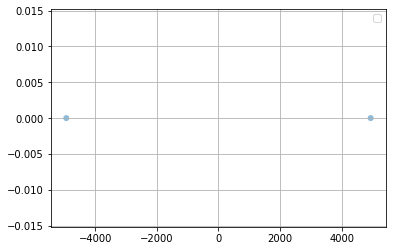

In [38]:
plot(demand_orlando_zip[['zip_lat','zip_lon']].values.T, v, u, c)

In [ ]:
from fcmeans import FCM

In [ ]:
demand_orlando[['lat_adr','lon_adr']].to_numpy()

In [ ]:
fuzzy_c_means = FCM(n_clusters=4) # we use two cluster as an example
fuzzy_c_means.fit(demand_orlando[['lat_adr','lon_adr']].to_numpy()) ## X, numpy array. rows:samples columns:features

In [281]:
n_samples = 3000

X = np.concatenate((
    np.random.normal((-2, -2), size=(n_samples, 2)),
    np.random.normal((2, 2), size=(n_samples, 2))
))

In [278]:
X

array([[-2.79223118, -2.14957943],
       [-1.90608467, -3.20653654],
       [-0.7724569 , -2.16797665],
       ...,
       [ 3.12672754,  2.5020757 ],
       [ 1.99857442,  1.69024909],
       [ 0.93174426,  3.02911431]])

In [282]:
fcm = FCM(n_clusters=2)
fcm.fit(X)

ValidationError: 1 validation error for Fit
X
  field required (type=value_error.missing)